# Time series data upload

Custom data that cannot easily be brought into the QA4SM netCDF format, e.g. because time stamps of the data vary by location, can be uploaded as time series data. We support two different formats for this:
- a zipped directory containing CSV files
- a zipped directory containing a gridded contiguous ragged `pynetcf` dataset

The former format is the easier format and recommended for most users. The latter is only necessary if the data is very big and CSV files are therefore not suitable.

## CSV time series format

The CSV files have to comply with the following conditions:
- The file names have to follow the pattern `<name>_lat=<lat_in_degree>_lon=<lon_in_degree>.csv`
- The files must have a single header row, and the first column must be a datetime index. This is the default output format when using `pandas.DataFrame.to_csv` on a data frame with a `pandas.DatetimeIndex` as index. To test whether your files comply with this format, you can read them with `pandas.read_csv(<fname>, index_col=0, parse_dates=True)` and see if the resulting data frame is in the right format.
- All files must have the same column names.

Optionally, an additional file with filename `metadata.yml` containing metadata for each variable can be added to the directory. The format should follow this example:
```
soil_moisture_1:
  long_name: soil moisture 1
  units: m^3/m^3
soil_moisture_2:
  long_name: soil moisture 2
  units: m^3/m^3
```

If you have a list of time series as `pandas.Series` or `pandas.DataFrame` and their associated coordinates, you can also use `qa4sm_preprocessing.utils.make_csv_dataset` to create a dataset in the correct format.

The following shows an example of how to create a such a dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For now, assume that we have 3 timeseries (e.g. from in-situ data) from 3 different locations, with strongly varying timestamps:

In [2]:
# timeseries 1: daily timestamps
index = pd.date_range("2020-01-01 12:00", "2020-12-31 12:00", freq="D")
data = np.random.randn(len(index))
ts1 = pd.Series(data, index=index, name="soil_moisture")
lat1 = 12
lon1 = 0.1

# timeseries 2: hourly timestamps, but shorter period
index = pd.date_range("2020-06-01", "2020-08-01", freq="H")
data = np.random.randn(len(index)) + 2
ts2 = pd.Series(data, index=index, name="soil_moisture")
lat2 = 34
lon2 = 2.3

# timeseries 3: irregular timestamps
index = pd.DatetimeIndex(np.datetime64("2020-01-01") + np.random.rand(1000) * np.timedelta64(365*24*60, "m"))
data = np.random.randn(len(index)) - 2
ts3 = pd.Series(data, index=index, name="soil_moisture")
lat3 = 56
lon3 = 4.5

In [3]:
ts1

2020-01-01 12:00:00   -0.512381
2020-01-02 12:00:00   -0.633480
2020-01-03 12:00:00    0.343966
2020-01-04 12:00:00   -1.198470
2020-01-05 12:00:00   -1.322983
                         ...   
2020-12-27 12:00:00    1.442193
2020-12-28 12:00:00   -1.041904
2020-12-29 12:00:00    1.288115
2020-12-30 12:00:00   -0.637232
2020-12-31 12:00:00    0.745761
Freq: D, Name: soil_moisture, Length: 366, dtype: float64

In [4]:
ts2

2020-06-01 00:00:00    2.203082
2020-06-01 01:00:00    2.987946
2020-06-01 02:00:00    1.743539
2020-06-01 03:00:00    2.809635
2020-06-01 04:00:00    0.645591
                         ...   
2020-07-31 20:00:00    2.000760
2020-07-31 21:00:00    1.838077
2020-07-31 22:00:00    1.401902
2020-07-31 23:00:00    0.908552
2020-08-01 00:00:00    2.024142
Freq: H, Name: soil_moisture, Length: 1465, dtype: float64

In [5]:
ts3

2020-04-22 08:28:00   -3.340274
2020-02-07 09:32:00   -2.596822
2020-06-13 23:38:00   -1.694794
2020-11-02 21:35:00   -0.673691
2020-11-21 07:06:00   -0.957527
                         ...   
2020-05-15 23:19:00   -2.168376
2020-11-25 01:41:00   -3.906953
2020-03-23 20:24:00   -2.901255
2020-07-17 23:53:00   -0.543793
2020-10-26 04:35:00   -4.125654
Name: soil_moisture, Length: 1000, dtype: float64

<AxesSubplot:>

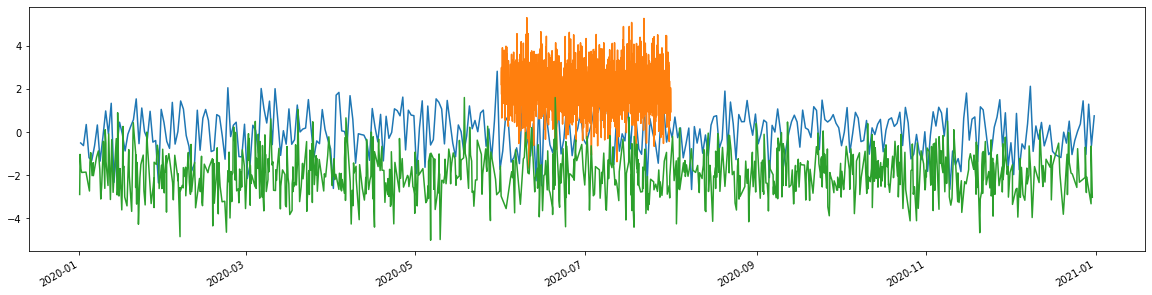

In [6]:
plt.figure(figsize=(20, 5))
ts1.plot()
ts2.plot()
ts3.plot()

We now have 3 timeseries, and the coordinates of them. We add some metadata to it and then create the csv directory.

In [7]:
lats = [lat1, lat2, lat3]
lons = [lon1, lon2, lon3]
timeseries = [ts1, ts2, ts3]
metadata = {"soil_moisture": {"units": "m^3/m^3", "long_name": "Volumetric soil moisture"}}


from qa4sm_preprocessing.utils import make_csv_dataset

make_csv_dataset(timeseries, lons, lats, "csv_soil_moisture", name="mydataset", metadata=metadata)

In [8]:
%ls csv_soil_moisture

 metadata.yml                   'mydataset_lat=2.3_lon=34.csv'
'mydataset_lat=0.1_lon=12.csv'  'mydataset_lat=4.5_lon=56.csv'


As expected, we have now 3 CSV files and a `metadata.yml` file in our directory. We can test whether they conform to the format required by QA4SM by reading them with `pandas.read_csv`.

                     soil_moisture
2020-01-01 12:00:00      -0.512381
2020-01-02 12:00:00      -0.633480
2020-01-03 12:00:00       0.343966
2020-01-04 12:00:00      -1.198470
2020-01-05 12:00:00      -1.322983
...                            ...
2020-12-27 12:00:00       1.442193
2020-12-28 12:00:00      -1.041904
2020-12-29 12:00:00       1.288115
2020-12-30 12:00:00      -0.637232
2020-12-31 12:00:00       0.745761

[366 rows x 1 columns]
                     soil_moisture
2020-06-01 00:00:00       2.203082
2020-06-01 01:00:00       2.987946
2020-06-01 02:00:00       1.743539
2020-06-01 03:00:00       2.809635
2020-06-01 04:00:00       0.645591
...                            ...
2020-07-31 20:00:00       2.000760
2020-07-31 21:00:00       1.838077
2020-07-31 22:00:00       1.401902
2020-07-31 23:00:00       0.908552
2020-08-01 00:00:00       2.024142

[1465 rows x 1 columns]
                     soil_moisture
2020-04-22 08:28:00      -3.340274
2020-02-07 09:32:00      -2.596822
2020-0

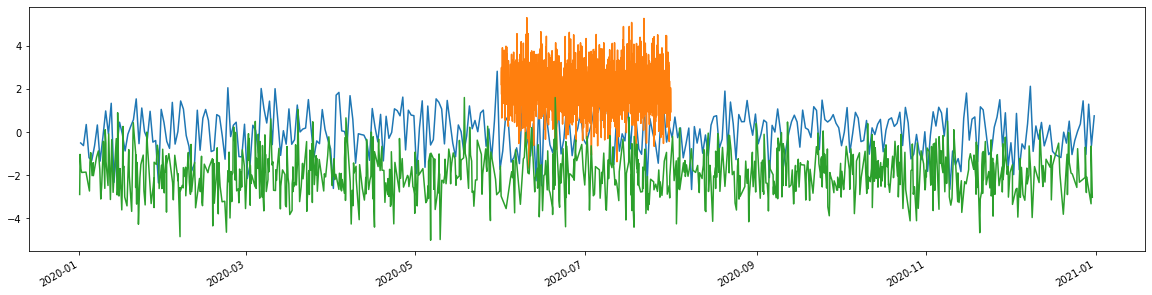

In [9]:
from pathlib import Path
import yaml

plt.figure(figsize=(20, 5))
for fname in Path("csv_soil_moisture").iterdir():
    if str(fname).endswith(".csv"):
        df = pd.read_csv(fname, index_col=0, parse_dates=True)
        df["soil_moisture"].plot()
        print(df)
    else:  # yaml file
        with open(fname, "r") as f:
            metadata = yaml.load(f, Loader=yaml.SafeLoader)
        print(metadata)

All CSV files could be read successfully, and the metadata has also been reproduced.

## Contiguous ragged format

As alternative to a zipped directory of CSV files, a zipped [pynetcf](https://pynetcf.readthedocs.io/en/latest/) `GriddedNcContiguousRaggedTs` dataset can be uploaded. To create the dataset (unzipped), we provide the function `make_gridded_contiguous_ragged_dataset` It has the same interface as `make_csv_dataset`, except that there is no `name` parameter.

In [13]:
from qa4sm_preprocessing.utils import make_gridded_contiguous_ragged_dataset

make_gridded_contiguous_ragged_dataset(timeseries, lons, lats, "pynetcf_soil_moisture", metadata=metadata)

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
%ls pynetcf_soil_moisture

0000.nc  grid.nc


In this case the dataset consists of a single data netCDF file (`0000.nc`) and a grid file (`grid.nc`). We can open the data netCDF with `xarray` to see if it looks good.

In [19]:
import xarray as xr
xr.open_dataset("pynetcf_soil_moisture/0000.nc").soil_moisture

<xarray.DataArray 'soil_moisture' (obs: 2831)>
array([-0.512381, -0.63348 ,  0.343966, ..., -2.901255, -0.543793, -4.125654])
Coordinates:
    time     (obs) datetime64[ns] ...
Dimensions without coordinates: obs
Attributes:
    name:       soil_moisture
    long_name:  Volumetric soil moisture
    units:      m^3/m^3

As expected, the variable "soil_moisture" has only a single dimension. The metadata has also been successfully written.

To read the dataset we can use the `GriddedNcContiguousRaggedTs` reader in `qa4sm_preprocessing.reading`.

                     soil_moisture
2020-01-01 12:00:00      -0.512381
2020-01-02 12:00:00      -0.633480
2020-01-03 12:00:00       0.343966
2020-01-04 12:00:00      -1.198470
2020-01-05 12:00:00      -1.322983
...                            ...
2020-12-27 12:00:00       1.442193
2020-12-28 12:00:00      -1.041904
2020-12-29 12:00:00       1.288115
2020-12-30 12:00:00      -0.637232
2020-12-31 12:00:00       0.745761

[366 rows x 1 columns]
                     soil_moisture
2020-06-01 00:00:00       2.203082
2020-06-01 01:00:00       2.987946
2020-06-01 02:00:00       1.743539
2020-06-01 03:00:00       2.809635
2020-06-01 04:00:00       0.645591
...                            ...
2020-07-31 20:00:00       2.000760
2020-07-31 21:00:00       1.838077
2020-07-31 22:00:00       1.401902
2020-07-31 23:00:00       0.908552
2020-08-01 00:00:00       2.024142

[1465 rows x 1 columns]
                     soil_moisture
2020-04-22 08:28:00      -3.340274
2020-02-07 09:32:00      -2.596822
2020-0

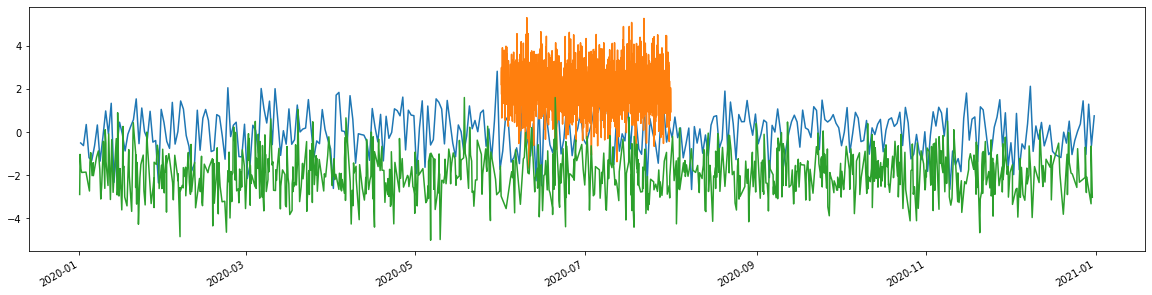

In [20]:
from qa4sm_preprocessing.reading import GriddedNcContiguousRaggedTs

ds = GriddedNcContiguousRaggedTs("pynetcf_soil_moisture")

plt.figure(figsize=(20, 5))
for gpi in range(3):
    df = ds.read(gpi)
    print(df)
    df["soil_moisture"].plot()

Again, the reading of the individual time series reproduced the input data, so after zipping the directory it can be uploaded to QA4SM.